In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy import spatial
import matplotlib.pyplot as plt
from astropy.table import Table
import matplotlib.cm as cm
import emcee
import corner
import pdb

The UV luminosity function can be obtained from a combination of Table 1 in Cucciati et al. 2012 and Table 6 in Bouwens et al. 2015.

In [123]:
import astropy.units as u
import astropy.constants as c


z = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.5, 2.1, 3, 4,  4.9, 5.9, 6.8, 7.9])
M_s = np.array([-18.12, -18.3, -18.4, -18.3, -18.7, -19.0, -19.6, -20.4, -21.4, -22.2,  -21.17, -20.94, -20.87, -20.63])
alpha = np.array([-1.05, -1.17, -1.07, -0.9, -0.85, -0.91, -1.09, -1.3, -1.5, -1.73,  -1.76, -1.87, -2.06, -2.02])
phi_s = np.array([7, 6.91, 6.6, 9.53, 9.01, 7.43, 4.10, 3.37, 0.86, 0.11,  0.74, 0.5, 0.29, 0.21])
phie_s = np.array([0.44, 1.02, 0.91, 0.99, 0.96, 1.15, 0.87, 0.24, 0.05, 0.01, 0.18, 0.22, 0.21, 0.23])
L_s = 10**((M_s + 48.6)/-2.5)*4*np.pi*(10*u.pc.to(u.cm))**2

Integrate over luminosity, we get the luminosity density (see Equ 14 in Madau & Dickinson).

In [124]:
def gamma_func(a,x):
    xx = np.arange(x, 1e5, 0.01)
    yy = xx**(a-1) * np.exp(-xx)
    return np.trapz(yy, x=xx)

In [125]:
# calculate luminosity density 
rho = np.zeros(len(z))
rhoe = np.zeros(len(z))
for i in range(len(z)):
    rho[i] = gamma_func(alpha[i]+2, 0.03)*phi_s[i]*1e-3*L_s[i]
    rhoe[i] = gamma_func(alpha[i]+2, 0.03)*phie_s[i]*1e-3*L_s[i]
np.log10(rho)

array([ 25.728567  ,  25.82577083,  25.81961237,  25.90662016,
        26.03540748,  26.08002924,  26.09766417,  26.39635364,
        26.28783542,  25.84199666,  26.27680523,  26.08869195,
        25.96862632,  25.70035379])

In [126]:
# use results from Homework5 problem1, convert luminosity density to SFR density
lambda_eff = 1535
vFv = rho*(c.c.to(u.angstrom*u.Hz).value) / lambda_eff
log_SFR = np.log10(vFv) - 43.34
vFve = rhoe*(c.c.to(u.angstrom*u.Hz).value) / lambda_eff
log_SFRe = np.log10(vFve) - 43.34

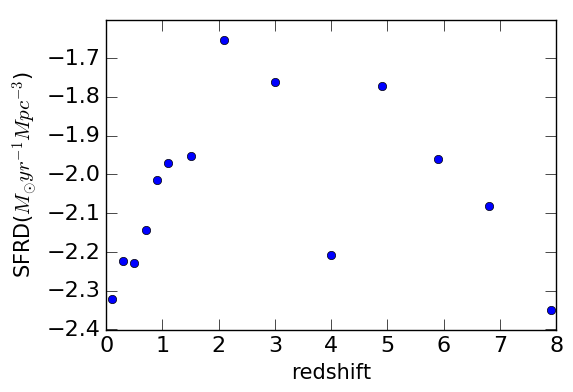

In [129]:
# plot SFRD as a function of redshift
plt.clf()
#plt.errorbar(z, log_SFR, yerr=log_SFRe)
plt.plot(z, log_SFR, 'o')
plt.xlabel('redshift')
plt.ylabel(r'SFRD($M_{\odot} yr^{-1} Mpc^{-3}$)')

My result has a similar shape as in Madau & Dickinson (2014) and Finkelstein et al. (2015). The SFRD all peaks at around z =2. But my SFRD is overall smaller than their result. The main reason is I didn't correct for dust. As you can see in Fig 19 in Finkelstein et al. (2015), my results agree well with the curve before dust correction. And also, when redshift=4, in my plot, the SFRD seems to be smaller than the overall trend. This data point is from  Cucciati et al. 2012. It's very probable that this point is a bad point and I will drop it later.

(b)

[ 0.00477837  0.005977    0.00589284  0.0072      0.00968545  0.01073351
  0.01117832  0.02223648  0.01731999  0.01688564  0.01094975  0.00830498
  0.00447781]


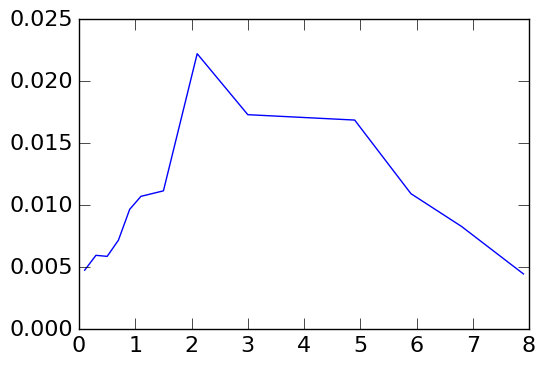

In [218]:
print(10**log_SFR)
plt.plot(z, 10**log_SFR)


[ 0.23005466  0.29414349  0.36094507  0.42745005  0.48920334  0.54036389
  0.58676521  0.49406573  0.25378687  0.05561097  0.0286966   0.01700701
  0.00966418]


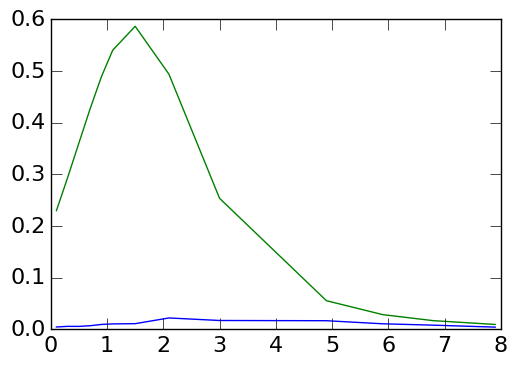

In [235]:
#theta = np.array([ 2.69720932,  5.61357871,  0.97795656,  3.00167849])
#SFR_z(theta, z)
theta0 = [1.5, 5.8, 0.2, 3]
print(SFR_z(theta0, z))
plt.plot(z, 10**log_SFR)
plt.plot(z, SFR_z(theta0, z))

In [239]:
# fit phi_s as a function of z in the form of Equ7 in Finkelstein et al. (2015)
def SFR_z(theta, z):
    alpha, gamma, A, B = theta
    if B<0:
        return 1e1000
    else:
        return A * (1+z)**alpha / (1+((1+z)/B)**gamma)

def ln_prior(theta):
    alpha, gamma, A, B = theta
    if alpha<1.5 or alpha>3.5: 
        return -1e1000
    elif gamma<4 or gamma>7 or gamma<alpha:
        return -1e1000
    elif A<0 or A>0.2:
        return -1e1000
    elif B<0 or B>5:
        return -1e1000
    else:
        return 0
    
def ln_likelihood(theta, z, SFR):
    SFR_model = SFR_z(theta, z)
    chi2 = -np.sum((SFR_model-SFR)**2)
    return chi2

def ln_posterior(theta, z, SFR):
    return ln_prior(theta) + ln_likelihood(theta, z, SFR)



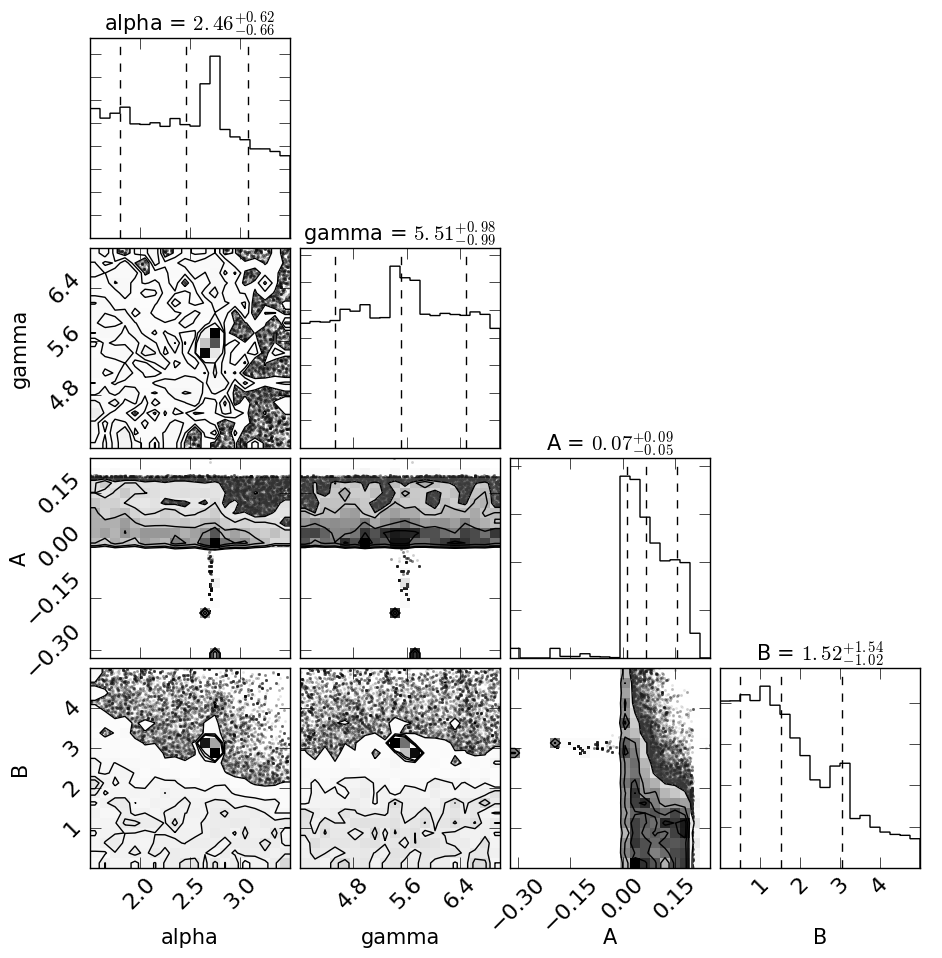

In [240]:
# drop redshit=4 point
#idx = np.where(z==4)[0][0]
#z = np.delete(z, idx)
#log_SFR = np.delete(log_SFR, idx)

# run mcmc to get the best fit quadratic function
steps = 1000
nwalkers = 100
ndim = 4
theta0 = [2.7, 5.6, 0.02, 3]
pos = [np.random.normal((theta0), (0.01, 0.1, 0.1, 0.1)) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(z, 10**log_SFR))
sampler.run_mcmc(pos, steps)
samples = sampler.chain.reshape((-1, ndim))
corner.corner(samples, labels=['alpha', 'gamma', 'A', 'B'], quantiles=[0.16, 0.5, 0.84], show_titles=True)
print('')

In [233]:
sampler.acceptance_fraction

array([ 0.314,  0.327,  0.387,  0.308,  0.304,  0.278,  0.353,  0.289,
        0.337,  0.355,  0.243,  0.294,  0.287,  0.285,  0.324,  0.321,
        0.324,  0.252,  0.344,  0.341,  0.338,  0.35 ,  0.332,  0.308,
        0.322,  0.38 ,  0.305,  0.363,  0.335,  0.34 ,  0.344,  0.322,
        0.308,  0.331,  0.29 ,  0.342,  0.297,  0.307,  0.306,  0.332,
        0.361,  0.34 ,  0.306,  0.358,  0.339,  0.325,  0.388,  0.309,
        0.338,  0.282,  0.312,  0.309,  0.332,  0.342,  0.379,  0.354,
        0.32 ,  0.329,  0.368,  0.303,  0.338,  0.382,  0.343,  0.33 ,
        0.335,  0.306,  0.361,  0.319,  0.362,  0.32 ,  0.34 ,  0.322,
        0.33 ,  0.318,  0.347,  0.316,  0.35 ,  0.33 ,  0.328,  0.325,
        0.334,  0.316,  0.349,  0.348,  0.337,  0.301,  0.31 ,  0.323,
        0.321,  0.299,  0.312,  0.312,  0.312,  0.331,  0.288,  0.305,
        0.31 ,  0.298,  0.352,  0.343])

In [234]:
sampler.lnprobability

array([[ -2.51724411e+00,  -2.98844130e+00,  -4.46767814e+00, ...,
         -1.12277459e+00,  -7.03412915e-01,  -7.03412915e-01],
       [ -1.10044840e+00,  -1.10044840e+00,  -1.10044840e+00, ...,
         -1.86993341e-02,  -1.86993341e-02,  -1.55739145e-01],
       [ -3.99103997e+00,  -3.99103997e+00,  -3.99103997e+00, ...,
         -4.12392013e-01,  -4.83473774e-01,  -4.83473774e-01],
       ..., 
       [ -2.06902083e+00,  -8.70093296e-01,  -9.57093181e-01, ...,
         -1.16786463e-01,  -7.96282909e-02,  -7.96282909e-02],
       [            -inf,             -inf,             -inf, ...,
         -1.76758229e-03,  -1.76758229e-03,  -1.76758230e-03],
       [            -inf,             -inf,             -inf, ...,
         -2.32704910e-01,  -1.31923932e-01,  -3.25074487e-01]])

In [ ]:
sampler